# Bit coin close prediction using RNN & LSTM

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv


**In RNN,as the gradient of the training samples gets propagated backward through our network, it gets weaker and weaker, by the time it gets to those neurons that represent older data points in our time-series it has no juice to adjust them properly. This problem is called Vanishing Gradient. A LSTM cell is a type of RNN which stores important information about the past and forgets the unimportant pieces. In this way, when gradient back-propagates, it won’t be consumed by unnecessary information.**

In [2]:
df=pd.read_csv('../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv')

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4572252,1600041360,10324.35,10325.89,10324.35,10325.89,0.081143,837.754188,10324.419779
4572253,1600041420,10331.41,10331.97,10326.68,10331.97,0.572817,5918.028741,10331.444396
4572254,1600041480,10327.20,10331.47,10321.33,10331.47,2.489909,25711.238323,10326.175283
4572255,1600041540,10330.02,10334.78,10328.64,10334.78,4.572660,47253.747619,10333.972651
4572256,1600041600,10338.82,10338.82,10332.37,10332.37,1.292006,13349.565122,10332.429402


In [5]:
df.dtypes

Timestamp              int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

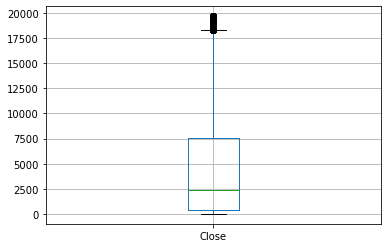

In [6]:
df[['Close']].boxplot()

**As timestamp field is of int type, we have to convert that to date type**

In [7]:
df['Date']=pd.to_datetime(df['Timestamp'],unit='s').dt.date
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31


In [8]:
group=df.groupby('Date')
group.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
...,...,...,...,...,...,...,...,...,...
4570817,1599955260,10441.23,10441.23,10434.92,10434.92,2.177153,22729.334794,10439.932282,2020-09-13
4570818,1599955320,10437.36,10441.00,10435.18,10441.00,4.116903,42972.501030,10438.064372,2020-09-13
4570819,1599955380,10435.90,10435.90,10435.90,10435.90,2.420724,25262.432965,10435.900000,2020-09-13
4570820,1599955440,10432.10,10436.73,10428.65,10435.59,2.662243,27778.165678,10434.121776,2020-09-13


In [9]:
data=group['Close'].mean()
data.head()

Date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

In [10]:
data.shape

(3178,)

In [11]:
data.isnull().sum()

0

In [12]:
data.head()

Date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

# Train test split

In [13]:
len(data)

3178

**Taking last 50 records for test & remaining for train set**

In [14]:
x_train=data.iloc[:len(data)-50]
x_test=data.iloc[len(x_train):]

In [15]:
x_train.shape

(3128,)

In [16]:
x_test.shape

(50,)

# Feature scaling

In [17]:
x_train=np.array(x_train)
x_train.shape

(3128,)

In [18]:
x_train=x_train.reshape(x_train.shape[0],1)
x_train.shape

(3128, 1)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
xtrain_scaled=scaler.fit_transform(x_train)

In [20]:
type(xtrain_scaled)

numpy.ndarray

In [21]:
xtrain_scaled.shape

(3128, 1)

In [22]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,xtrain_scaled.shape[0]):
    x_train.append(xtrain_scaled[i-timestep:i,0])
    y_train.append(xtrain_scaled[i,0])

**In the above loop, we took the previous value of a set at y and nxt 50 samples at x, for training the RNN**

In [23]:
len(x_train)

3078

In [24]:
x_train

[array([7.86163155e-06, 2.47576242e-05, 3.48344116e-05, 4.79950434e-05,
        4.64748384e-05, 1.01872349e-04, 1.10149711e-04, 1.28652777e-04,
        1.36470974e-04, 1.17272957e-04, 1.18384878e-04, 1.45429325e-04,
        1.42334622e-04, 1.37008475e-04, 1.08325465e-04, 1.46895237e-04,
        1.24185236e-04, 9.43395786e-05, 9.97109695e-05, 9.87202509e-05,
        1.30477023e-04, 1.07074553e-04, 1.12234563e-04, 1.08195161e-04,
        1.12784732e-04, 1.01651041e-04, 9.65981688e-05, 6.87877248e-05,
        3.01434933e-05, 7.11108462e-05, 6.32405278e-05, 6.70987763e-05,
        7.59450981e-05, 9.58620696e-05, 9.76309430e-05, 9.19398264e-05,
        7.85728810e-05, 6.22632532e-05, 6.98599347e-05, 7.35779218e-05,
        7.56751842e-05, 8.05407948e-05, 6.63678066e-05, 6.80617494e-05,
        6.86184998e-05, 4.48954047e-05, 3.19814555e-05, 1.27135127e-05,
        1.87256680e-05, 3.44134318e-06]),
 array([2.47576242e-05, 3.48344116e-05, 4.79950434e-05, 4.64748384e-05,
        1.01872349e-04

In [25]:
x_train,y_train=np.array(x_train),np.array(y_train)

In [26]:
x_train.shape

(3078, 50)

In [27]:
y_train

array([0.00000000e+00, 1.19382629e-05, 7.91049528e-06, ...,
       4.97902202e-01, 5.01139385e-01, 5.12353767e-01])

In [28]:
y_train

array([0.00000000e+00, 1.19382629e-05, 7.91049528e-06, ...,
       4.97902202e-01, 5.01139385e-01, 5.12353767e-01])

In [29]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (3078, 50, 1)
y_train shape=  (3078,)


# RNN model

In [30]:
import keras
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,Dropout,Flatten

In [31]:
reg=Sequential()

reg.add(SimpleRNN(128,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
reg.add(Dropout(0.25))

reg.add(SimpleRNN(256,return_sequences=True,activation='relu'))
reg.add(Dropout(0.25))

reg.add(SimpleRNN(512,return_sequences=True,activation='relu'))
reg.add(Dropout(0.35))

reg.add(SimpleRNN(256,return_sequences=True,activation='relu'))
reg.add(Dropout(0.25))

reg.add(SimpleRNN(128,return_sequences=True,activation='relu'))
reg.add(Dropout(0.25))

reg.add(Flatten())

reg.add(Dense(1))


reg.compile(optimizer='adam',loss='mean_squared_error')
reg.fit(x_train,y_train,epochs=100,batch_size=64)


Epoch 1/100
49/49 [==============================] - 14s 292ms/step - loss: 0.0083
Epoch 2/100
49/49 [==============================] - 14s 288ms/step - loss: 0.0025
Epoch 3/100
49/49 [==============================] - 14s 294ms/step - loss: 0.0016
Epoch 4/100
49/49 [==============================] - 16s 319ms/step - loss: 0.0016
Epoch 5/100
49/49 [==============================] - 14s 291ms/step - loss: 0.0013
Epoch 6/100
49/49 [==============================] - 14s 289ms/step - loss: 0.0012
Epoch 7/100
49/49 [==============================] - 14s 287ms/step - loss: 0.0012
Epoch 8/100
49/49 [==============================] - 15s 303ms/step - loss: 0.0011
Epoch 9/100
49/49 [==============================] - 14s 287ms/step - loss: 0.0012
Epoch 10/100
49/49 [==============================] - 14s 291ms/step - loss: 8.7913e-04
Epoch 11/100
49/49 [==============================] - 14s 286ms/step - loss: 7.9535e-04
Epoch 12/100
49/49 [==============================] - 15s 299ms/step - loss: 

# Processing test data for prediction

In [32]:
inputs=data[len(data)-len(x_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [33]:
xtest=[]
for i in range(timestep,inputs.shape[0]):
    xtest.append(inputs[i-timestep:i,0])
xtest=np.array(xtest)
xtest=xtest.reshape(xtest.shape[0],xtest.shape[1],1)

In [34]:
predicted_data=reg.predict(xtest)
predicted_data=scaler.inverse_transform(predicted_data)

In [35]:
data_test=np.array(x_test)
data_test=data_test.reshape(len(data_test),1)

In [36]:
import matplotlib.pyplot as plt

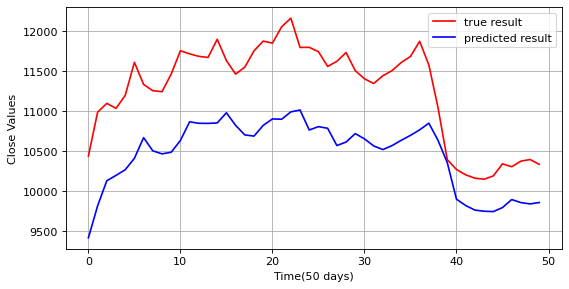

In [37]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

# Using LSTM

In [38]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
97/97 [==============================] - 3s 31ms/step - loss: 0.0533
Epoch 2/100
97/97 [==============================] - 3s 28ms/step - loss: 6.0409e-04
Epoch 3/100
97/97 [==============================] - 2s 24ms/step - loss: 3.6752e-04
Epoch 4/100
97/97 [==============================] - 2s 24ms/step - loss: 3.4348e-04
Epoch 5/100
97/97 [==============================] - 2s 24ms/step - loss: 3.1842e-04
Epoch 6/100
97/97 [==============================] - 3s 28ms/step - loss: 3.0871e-04
Epoch 7/100
97/97 [==============================] - 3s 34ms/step - loss: 2.7533e-04
Epoch 8/100
97/97 [==============================] - 3s 35ms/step - loss: 2.7315e-04
Epoch 9/100
97/97 [==============================] - 3s 34ms/step - loss: 2.6182e-04
Epoch 10/100
97/97 [==============================] - 3s 31ms/step - loss: 2.6829e-04
Epoch 11/100
97/97 [==============================] - 2s 26ms/step - loss: 2.4726e-04
Epoch 12/100
97/97 [==============================] - 2s 18ms/step 

In [39]:
inputs=data[len(data)-len(x_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [40]:
xtest=[]
for i in range(timestep,inputs.shape[0]):
    xtest.append(inputs[i-timestep:i,0])
xtest=np.array(xtest)
xtest=xtest.reshape(xtest.shape[0],xtest.shape[1],1)

In [41]:
predicted_data=model.predict(xtest)
predicted_data=scaler.inverse_transform(predicted_data)

In [42]:
data_test=np.array(x_test)
data_test=data_test.reshape(len(data_test),1)

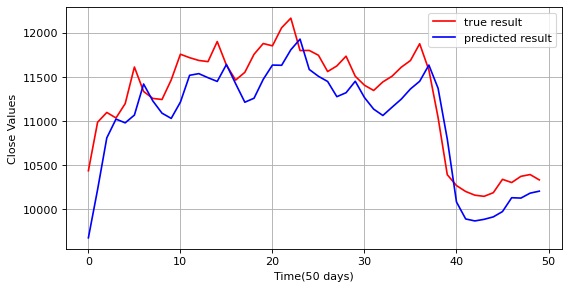

In [43]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

**From the above two plots, we can able to see that the LSTM model performs well than the RNN model**